In [1]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import pandas_datareader as web
import requests
import zipfile as zi 
from io import BytesIO as sio
from sklearn import datasets, linear_model
import scipy.special as scsp
import math
import seaborn as sns; sns.set()
import yfinance as yf
%matplotlib inline

In [2]:
url = 'https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip'
data = requests.get(url, stream=True).content

z = zi.ZipFile(sio(data))
z.extractall()

df = pd.read_csv('OxfordManRealizedVolatilityIndices.csv', index_col=0, header=2 )
rv1 = pd.DataFrame(index=df.index)
for col in df.columns:
    if col[-3:] == '.rk':
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

spx1 = pd.DataFrame(rv1['SPX2.rk'])
spx1['sqrt']= np.sqrt(spx1['SPX2.rk'])
spx1['log_sqrt'] = np.log(spx1['sqrt'])

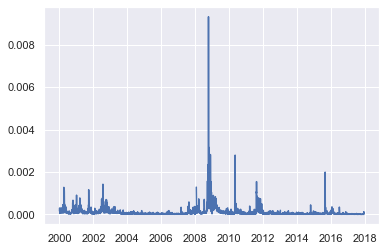

In [3]:
plt.plot(rv1.iloc[:,0])

In [4]:
#Download Sp500 Data
ticker_object = yf.Ticker("SPY")
SPX = ticker_object.history(start=spx1.index[0], end=spx1.index[-1])
SPX_close = SPX['Close']


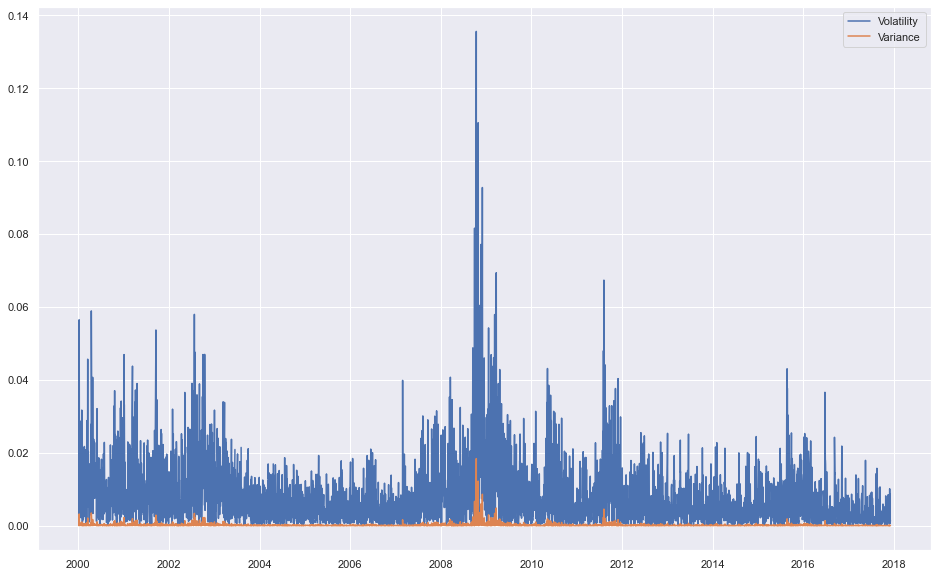

In [7]:
def close_to_close_vol(SPX):
    
    window =1
    log_returns = np.log(SPX.loc[:, "Close"]) - np.log(SPX.loc[:, "Close"].shift(1))
    
    sigma_cc = np.sqrt(1/window * pd.DataFrame.rolling(log_returns**2, window=window).sum())
    return sigma_cc

sigma_cc = close_to_close_vol(SPX)
var_cc = sigma_cc**2
plt.figure(figsize=(16,10))
plt.plot(sigma_cc.loc["2000-01-03":"2017-12-05"], label="Volatility")
plt.plot(var_cc.loc["2000-01-03":"2017-12-05"], label ="Variance")
plt.legend()
plt.show()
spx3 = pd.DataFrame(data=var_cc)
spx3["Log Return Var"] = spx3["Close"]
spx3['sqrt']= np.sqrt(spx3["Log Return Var"])
spx3['log_sqrt'] = np.log(spx3['sqrt'])
spx3=spx3[spx3["Log Return Var"] > 0.]
spx3=spx3.dropna()

In [8]:
spx2

NameError: name 'spx2' is not defined

In [9]:
SPX.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,98.728044,98.728044,95.814485,96.855042,8164300,0.0,0
2000-01-04,95.585514,95.939303,92.994529,93.067368,8089800,0.0,0
2000-01-05,93.192226,94.253594,91.402469,93.233849,12177900,0.0,0
2000-01-06,92.984126,94.232794,91.735458,91.735458,6227200,0.0,0
2000-01-07,93.442010,97.063148,93.275521,97.063148,8066500,0.0,0


In [10]:



"Missing N from calculations! Paper is wrong?"

def GKYZ_vol(SPX):
    
    # Estimating over total Range
    a_list = list()
    b_list = list()
    c_list = list()

    N = len(SPX) # number of days
    F = 1 # samples per day
    window = 1 # avg num days in a month: 22
    horizon = window # The time horizon of the estimation, yearly_vol=252, monthly_vol=22, daily_vol=1

    for i in range(len(SPX)):
        try:
            high_t = SPX.iloc[i+1,1]
            low_t = SPX.iloc[i+1,2]

            open_t0 = SPX.iloc[i,0]
            open_t = SPX.iloc[i+1,0]

            close_t0 = SPX.iloc[i,3]
            close_t = SPX.iloc[i+1,3]

            a = np.log(open_t/close_t0)**2
            b = (1/2) * np.log(high_t/low_t)**2
            c = (2 * np.log(2) - 1) * np.log(close_t/open_t)**2

            a_list.append(a)
            b_list.append(b)
            c_list.append(c)
        except IndexError:
            pass

    var_GKYZ_daily_mean = 1/N * (np.sum(a_list) + np.sum(b_list) - np.sum(c_list))  # Daily var
    vol_GKYZ_daily_mean = np.sqrt(var_GKYZ_daily_mean)  # Daily vol
    
    # Compute Rolling Window of Volatility
    var_gkyz_array = 1/window * (
                                    np.log(SPX.loc[:, "Open"] / SPX.loc[:, "Close"].shift(1))**2 + 
                                    (1/2) * np.log(SPX.loc[:, "High"] / SPX.loc[:, "Low"])**2 - 
                                    (2* np.log(2) - 1) * np.log(SPX.loc[:,"Close"] / SPX.loc[:, "Open"])**2
                                ).rolling(window=window).sum()
    vol_gkyz_array = np.sqrt(var_gkyz_array)
    
    
    
    return var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean

var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean = GKYZ_vol(SPX)

spx2 = pd.DataFrame(data=var_gkyz_array, columns=["GKYZ Var"])
spx2['sqrt']= np.sqrt(spx2["GKYZ Var"])
spx2['log_sqrt'] = np.log(spx2['sqrt'])
spx2=spx2[spx2["GKYZ Var"] > 0.]
spx2=spx2.dropna()

In [11]:
SPX.iloc[0+1,3]

93.06736755371094

Text(0.5, 1.0, 'Return Variance Estimates')

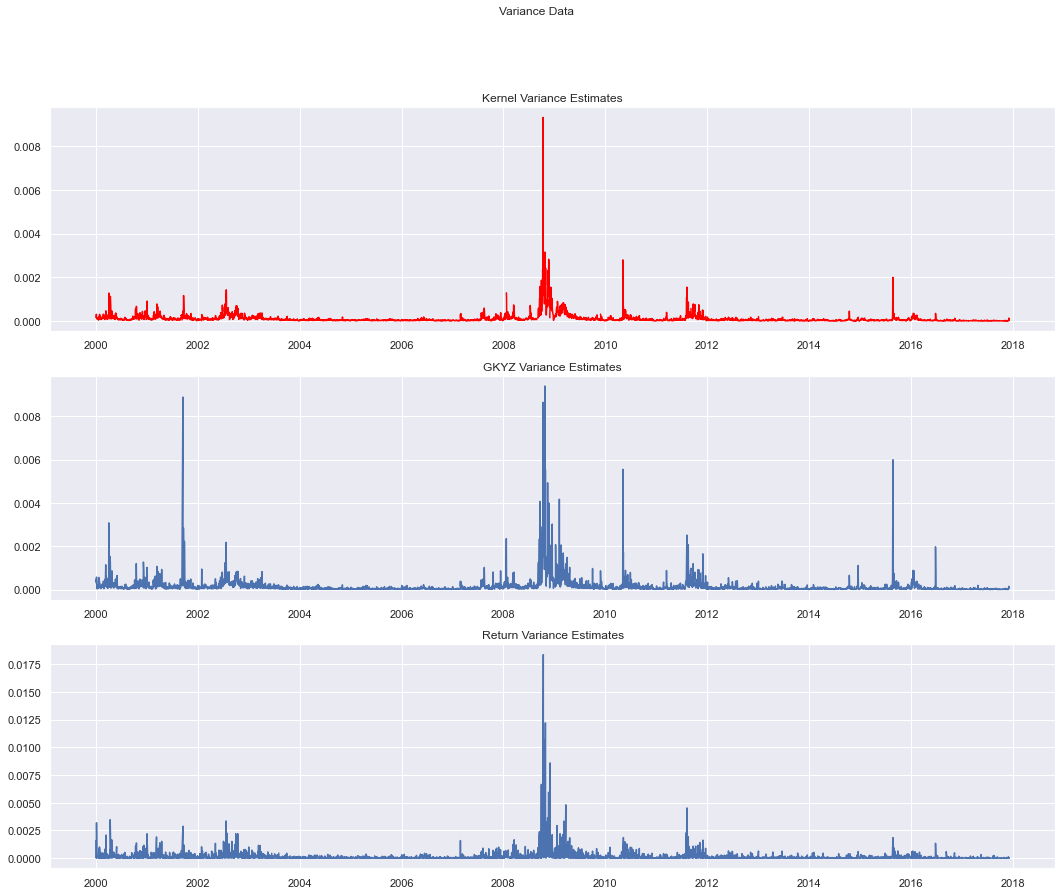

In [12]:
fig, axs =  plt.subplots(3, figsize=(18,14))
fig.suptitle("Variance Data")
axs[0].plot(spx1.index, spx1["SPX2.rk"].values, color='red')
axs[0].set_title("Kernel Variance Estimates")
axs[1].plot(var_gkyz_array.loc["2000-01-03":"2017-12-05"])
axs[1].set_title("GKYZ Variance Estimates")
axs[2].plot(var_cc)
axs[2].set_title("Return Variance Estimates")

In [40]:
kernel_gkyz_df = pd.merge(spx1["SPX2.rk"], var_gkyz_array, right_index=True, left_index=True)

In [55]:
def mse_fun(target, inpt):
    
    error = target - inpt
    squared_error = error**2
    mse = np.mean(squared_error)
    return mse

mse_gkyz = mse_fun(target=kernel_gkyz_df["SPX2.rk"], inpt=kernel_gkyz_df["GKYZ"])
mse_cc = mse_fun(target=kernel_gkyz_df["SPX2.rk"], inpt=var_cc)

print("The MSE between Kernel and GKYZ Variance Estimates is {} ".format(mse_gkyz))
print("The MSE between Kernel and Close to Close Variance Estimates is {} ".format(mse_cc))

The MSE between Kernel and GKYZ Variance Estimates is 7.353893125901533e-08 
The MSE between Kernel and Close to Close Variance Estimates is 2.2351900472861517e-07 


In [63]:
def del_Raw_kr(q, x): 
    return [np.mean(np.abs(spx1['log_sqrt'] - spx1['log_sqrt'].shift(lag)) ** q)
            for lag in x]

def del_Raw_gkyz(q, x): 
    return [np.mean(np.abs(spx2['log_sqrt'] - spx2['log_sqrt'].shift(lag)) ** q)
            for lag in x]

Kernel Estimates: 
[0.06978904021684623, 0.13658945475277, 0.20015260544030933, 0.2604388133907091, 0.37125103013938054]
------------------------------------------------------------------------------------------------------
GKYZ Estimates: 
[0.04274031761504921, 0.08427588062124994, 0.1246934194654504, 0.163912717047025, 0.23811351284031287]
Log Ret Estimates: 
[0.010083491777232459, 0.017818964796777477, 0.022714964728892645, 0.023746920693878952, 0.01474624618295957]


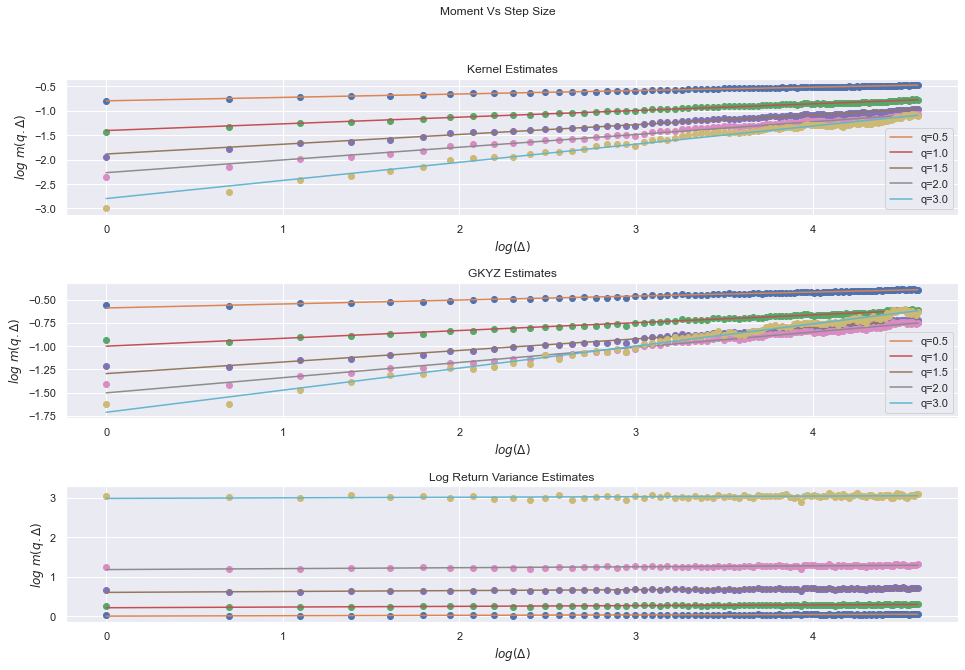

In [64]:
fig, axs =  plt.subplots(3, figsize=(16,10))
fig.suptitle("Moment Vs Step Size")
axs[0].set_title("Kernel Estimates")
axs[1].set_title("GKYZ Estimates")
axs[2].set_title("Log Return Variance Estimates")
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=0.5)
for ax in axs.flat:
    ax.set(xlabel='$log(\Delta)$', ylabel='$log\  m(q.\Delta)$')

def del_Raw_ret(q,x):
    m= [np.mean(np.abs(spx3["log_sqrt"] - spx3["log_sqrt"].shift(lag))**q) for lag in x]
    return m
    
    
zeta_q_kr = list()
zeta_q_gkyz = list()
zeta_q_ret = list()

qVec =  np.array([.5, 1, 1.5, 2, 3]) # np.arange(0.1,24,50/100) #
x = np.arange(1, 100)

for q in qVec:
    
    # Kernel Estimates
    axs[0].plot(np.log(x), np.log(del_Raw_kr(q, x)), 'o') 
    model_kr = np.polyfit(np.log(x), np.log(del_Raw_kr(q, x)), 1)
    axs[0].plot(np.log(x), np.log(x) * model_kr[0] + model_kr[1], label="q={}".format(q))
    axs[0].legend()
    zeta_q_kr.append(model_kr[0])
    
    # GKYZ Estimates
    axs[1].plot(np.log(x), np.log(del_Raw_gkyz(q, x)), 'o') 
    model_gkyz = np.polyfit(np.log(x), np.log(del_Raw_gkyz(q, x)), 1)
    axs[1].plot(np.log(x), np.log(x) * model_gkyz[0] + model_gkyz[1], label="q={}".format(q))
    axs[1].legend()
    zeta_q_gkyz.append(model_gkyz[0])    
    
    # Log Ret Estimates
    axs[2].plot(np.log(x), np.log(del_Raw_ret(q, x)), 'o') 
    model_Raw_ret = np.polyfit(np.log(x), np.log(del_Raw_ret(q, x)), 1)
    axs[2].plot(np.log(x), np.log(x) * model_Raw_ret[0] + model_Raw_ret[1], label="q={}".format(q))
    zeta_q_ret.append(model_Raw_ret[0])    
    
print("Kernel Estimates: ")   
print (zeta_q_kr) # this is the regression slope through all the points
print("------------------------------------------------------------------------------------------------------")
print("GKYZ Estimates: ")
print (zeta_q_gkyz)
print("Log Ret Estimates: ")
print (zeta_q_ret)

Kernel Estimate
H = 0.12032164592356559
GKYZ Estimate
H = 0.07807426624308078
Log Return Estimate
H = 0.0016456207102117683


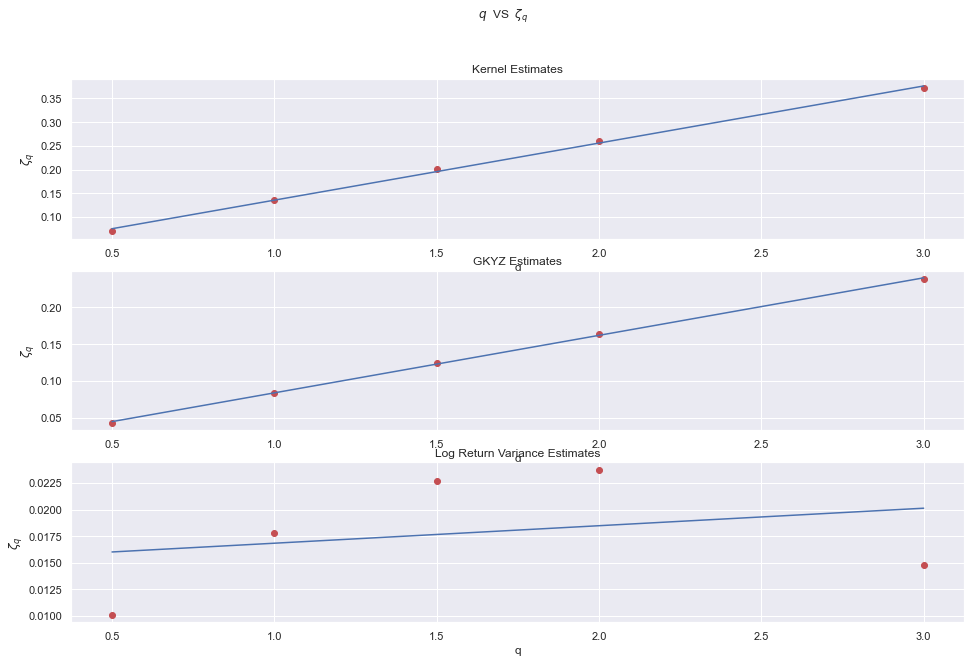

In [66]:
fig, axs =  plt.subplots(3, figsize=(16,10))
fig.suptitle("$q$  VS  $\zeta_{q}$")
axs[0].set_title("Kernel Estimates")
axs[1].set_title("GKYZ Estimates")
axs[2].set_title("Log Return Variance Estimates")

for ax in axs.flat:
    ax.set(xlabel='q', ylabel='$\zeta_{q}$')


line_kr = np.polyfit(qVec[:10], zeta_q_kr[:10],1)
line_gkyz = np.polyfit(qVec, zeta_q_gkyz,1)
line_logret = np.polyfit(qVec[:10], zeta_q_ret[:10],1)

axs[0].plot(qVec, zeta_q_kr, 'or')
axs[0].plot(qVec, line_kr[0] * qVec + line_kr[1])
axs[1].plot(qVec, zeta_q_gkyz, 'or')
axs[1].plot(qVec, line_gkyz[0] * qVec + line_gkyz[1])
axs[2].plot(qVec, zeta_q_ret, 'or')
axs[2].plot(qVec, line_logret[0] * qVec + line_logret[1])

h_est_kr= line_kr[0]
h_est_gkyz= line_gkyz[0]
h_est_logret= line_logret[0]

print("Kernel Estimate")
print("H = {}".format(h_est_kr))

print("GKYZ Estimate")
print("H = {}".format(h_est_gkyz))

print("Log Return Estimate")
print("H = {}".format(h_est_logret))

Kernel Estimates: 
[0.014164892325585422, 0.0834016747401428, 0.14956386537291294, 0.21247177618750812, 0.2721041187668712, 0.3284814021325036, 0.3816199125325927, 0.43152371979475074, 0.4782031455756621, 0.5217073778626083, 0.5621569544930493, 0.5997624787447332, 0.6348219810273419, 0.6676987973512343, 0.6987890531635106, 0.7284890928931873, 0.7571697289710715, 0.7851596880468491, 0.812737559525979, 0.8401302527242991, 0.8675158021914563, 0.8950286848989791, 0.9227662677463973, 0.9507954368967975, 0.979158819371637, 1.0078802802931355, 1.0369695711963671, 1.0664261286044292, 1.096242093116461, 1.1264046528897065, 1.1568978246916746, 1.1877037807208772, 1.2188038172045972, 1.250179045921622, 1.2818108749284907, 1.3136813312670248, 1.3457732668672855, 1.3780704793326581, 1.410557771656934, 1.4432209689251725, 1.47604690541175, 1.5090233919458493, 1.5421391707347631, 1.5753838628253933, 1.6087479118877677, 1.6422225268976804, 1.6757996254826684, 1.7094717791025686]
----------------------

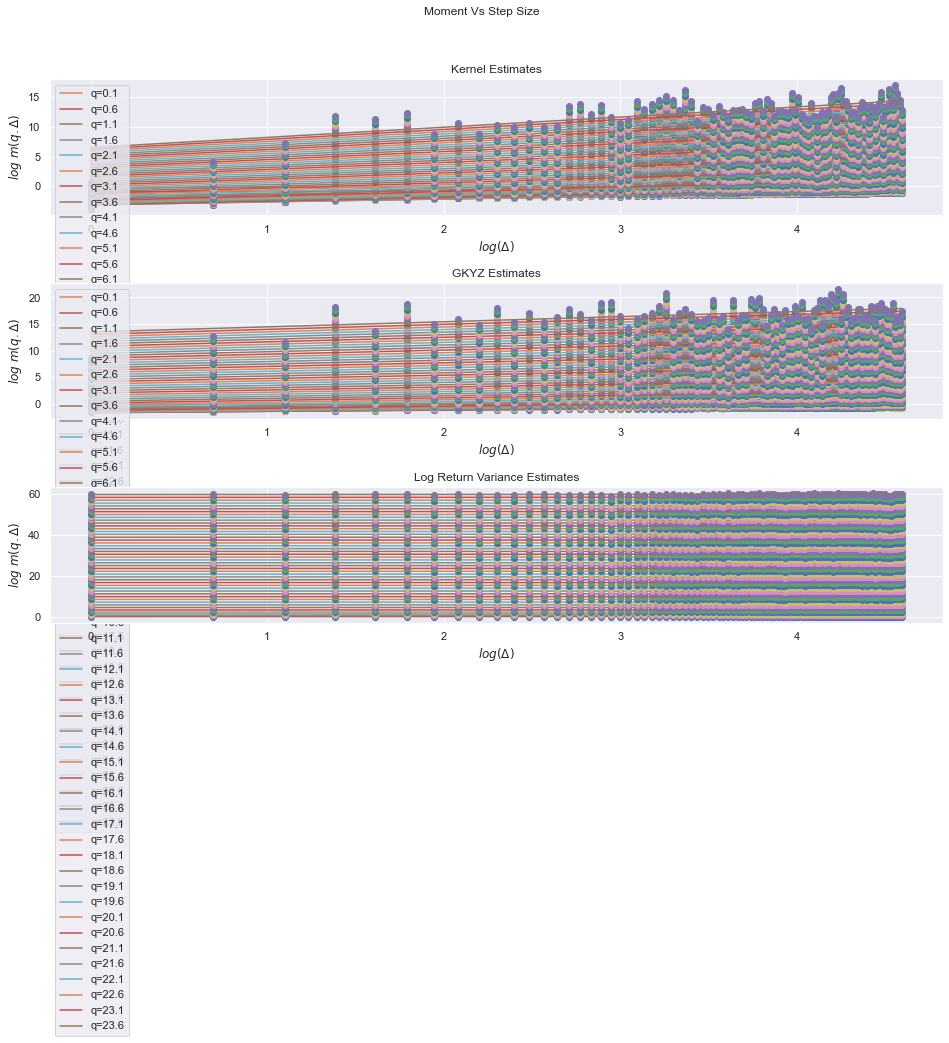

In [67]:
fig, axs =  plt.subplots(3, figsize=(16,10))
fig.suptitle("Moment Vs Step Size")
axs[0].set_title("Kernel Estimates")
axs[1].set_title("GKYZ Estimates")
axs[2].set_title("Log Return Variance Estimates")
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=0.5)
for ax in axs.flat:
    ax.set(xlabel='$log(\Delta)$', ylabel='$log\  m(q.\Delta)$')

def del_Raw_ret(q,x):
    m= [np.mean(np.abs(spx3["log_sqrt"] - spx3["log_sqrt"].shift(lag))**q) for lag in x]
    return m
    
    
zeta_q_kr = list()
zeta_q_gkyz = list()
zeta_q_ret = list()

qVec = np.arange(0.1,24,50/100) # np.array([.5, 1, 1.5, 2, 3]) #
x = np.arange(1, 100)

for q in qVec:
    
    # Kernel Estimates
    axs[0].plot(np.log(x), np.log(del_Raw_kr(q, x)), 'o') 
    model_kr = np.polyfit(np.log(x), np.log(del_Raw_kr(q, x)), 1)
    axs[0].plot(np.log(x), np.log(x) * model_kr[0] + model_kr[1], label="q={}".format(q))
    axs[0].legend()
    zeta_q_kr.append(model_kr[0])
    
    # GKYZ Estimates
    axs[1].plot(np.log(x), np.log(del_Raw_gkyz(q, x)), 'o') 
    model_gkyz = np.polyfit(np.log(x), np.log(del_Raw_gkyz(q, x)), 1)
    axs[1].plot(np.log(x), np.log(x) * model_gkyz[0] + model_gkyz[1], label="q={}".format(q))
    axs[1].legend()
    zeta_q_gkyz.append(model_gkyz[0])    
    
    # Log Ret Estimates
    axs[2].plot(np.log(x), np.log(del_Raw_ret(q, x)), 'o') 
    model_Raw_ret = np.polyfit(np.log(x), np.log(del_Raw_ret(q, x)), 1)
    axs[2].plot(np.log(x), np.log(x) * model_Raw_ret[0] + model_Raw_ret[1], label="q={}".format(q))
    zeta_q_ret.append(model_Raw_ret[0])    
    
print("Kernel Estimates: ")   
print (zeta_q_kr) # this is the regression slope through all the points
print("------------------------------------------------------------------------------------------------------")
print("GKYZ Estimates: ")
print (zeta_q_gkyz)
print("Log Ret Estimates: ")
print (zeta_q_ret)

In [68]:
def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print (a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

x = np.arange(1, 100)
h_roll = list()
daysinmonth = 22
rollwindow =  daysinmonth * 12 #len(spx1["SPX2.rk"])

for i in range(len(spx1["SPX2.rk"])-rollwindow+1):
    
    window_section = spx1["SPX2.rk"].iloc[i:rollwindow+i]
    
    sig = window_section
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    #nu.append(np.sqrt(np.exp(model[1])))
    h_roll.append(model[0]/2.)

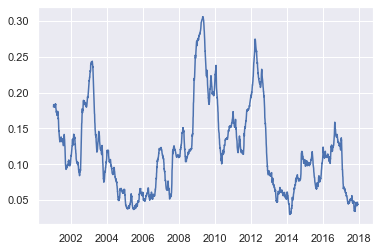

In [69]:
#plt.plot(spx1.index, spx1["SPX2.rk"].values, color='red')
plt.plot(spx1.index[rollwindow-1:], h_roll)

Text(0.5, 1.0, 'Kernel Variance Estimates vs 12 Month Rolling (Smoothed) Hurst Parameter Estimates')

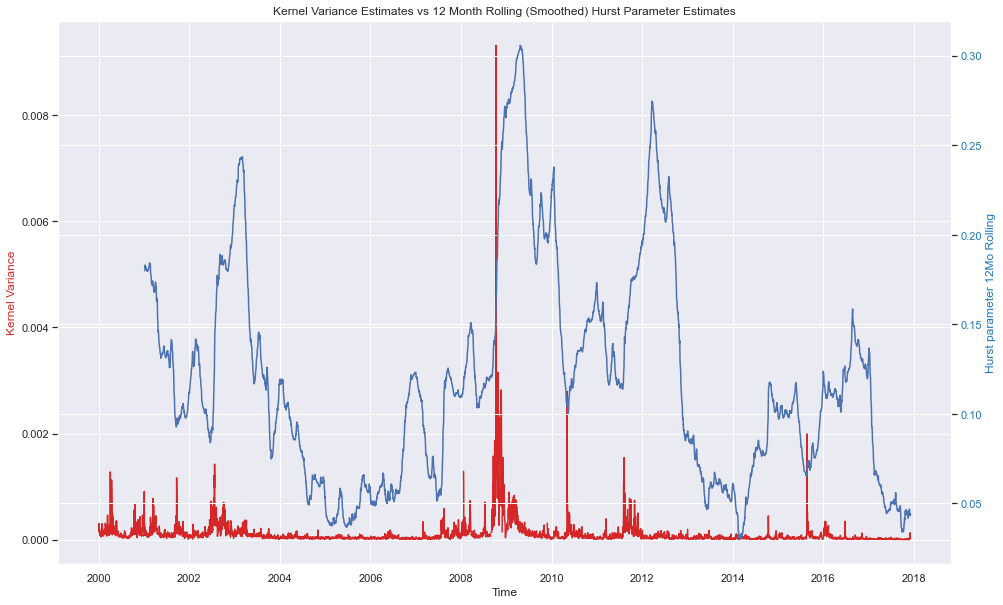

In [70]:
fig, ax1 = plt.subplots(figsize=(16,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Kernel Variance', color=color)
ax1.plot(spx1.index, spx1["SPX2.rk"].values, color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Hurst parameter 12Mo Rolling', color=color)  # we already handled the x-label with ax1
ax2.plot(spx1.index[rollwindow-1:], h_roll)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title("Kernel Variance Estimates vs 12 Month Rolling (Smoothed) Hurst Parameter Estimates")


In [71]:
daysinmonth = 22
rollwindow=daysinmonth * 12 

(0.0, 0.0035)

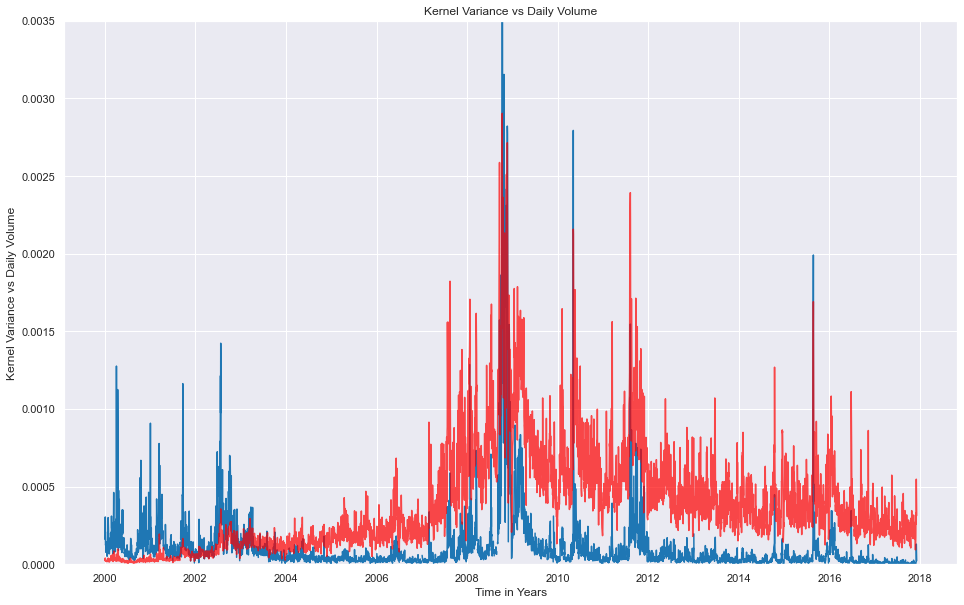

In [72]:
plt.figure(figsize=(16,10))

#plt.plot(SPX["Volume"].rolling(50).mean()/1000000000)
#plt.plot(spx1.index[rollwindow-1:], h_roll, color="black")
#plt.plot(SPX["Volume"].pct_change()/10, alpha=0.6)

plt.plot(spx1.index, spx1["SPX2.rk"].values, color=color)
plt.plot(SPX["Volume"]/300000000000, color="red", alpha=0.7)
plt.ylabel("Kernel Variance vs Daily Volume")
plt.xlabel("Time in Years")
plt.title("Kernel Variance vs Daily Volume")
plt.ylim(0,0.0035)

In [73]:
e = np.array([0,0])
c = np.cov(-0.4, 100)


"""
Produces random numbers for variance process with required
covariance structure.
"""
rng = np.random.multivariate_normal
rng(e, c, (30000, 100))

array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]]])

In [308]:
#from math import cov
np.cov(-0.4, 100)

array([[nan, nan],
       [nan, nan]])

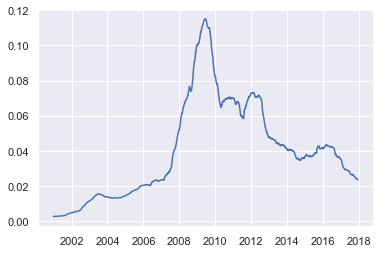

In [278]:
#When volume is high, roughness of volatility seems to be high as well

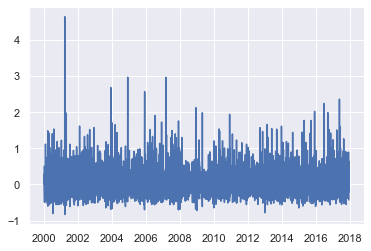

In [270]:
plt.plot(SPX["Volume"].pct_change())

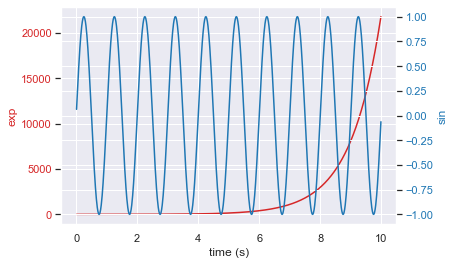

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)



In [76]:
from scipy.stats import norm

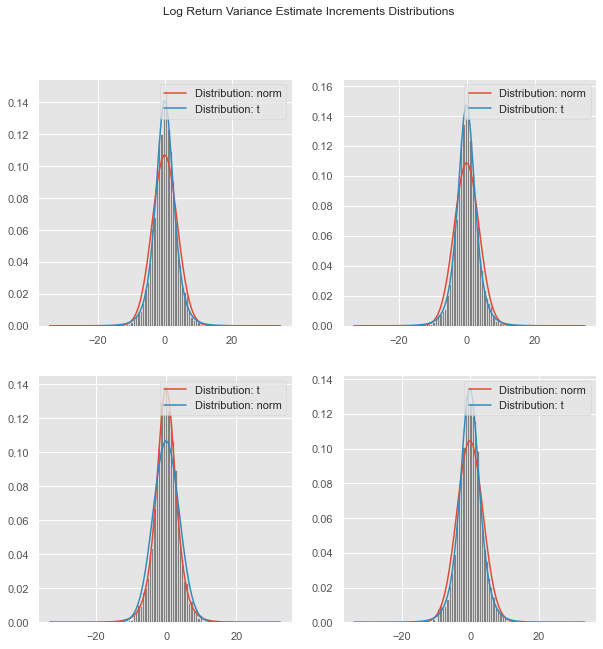

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [166]:
def xDel(x, lag):
    return x-x.shift(lag)

def sdl(lag):
    return (xDel(np.log(v), lag)).std()




f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10, 10))
f.suptitle("Log Return Variance Estimate Increments Distributions")
scaleFactor = 5

#v = spx1["SPX2.rk"]
#v = spx2["GKYZ Var"]
v = spx3["Log Return Var"]

x = np.arange(1,101)


for i_0 in range(0, 2):
    for i_1 in range(0, 2):
        la = scaleFactor ** (i_1*1+i_0*2)

        hist_val = xDel(np.log(v), la).dropna()
        std = hist_val.std()
        mean = hist_val.mean()
        #ax[i_0][i_1].set_title('Lag = %s Days' %la)
        #ax[i_0][i_1].hist(hist_val.values, bins=1000, facecolor='green',alpha=0.8)

        
        results = fit_data(hist_val)
        #plot_histogram(hist_val, results, 2)
        N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:2]}

        ## Histogram of data
        plt.figure(figsize=(10, 5))
        ax[i_0][i_1].hist(hist_val, density=True, ec='white', bins=100, color="grey")
        #plt.title('HISTOGRAM')
        #plt.xlabel('Values')
        #plt.ylabel('Frequencies')

        ## Plot n distributions
        for distribution, result in N_DISTRIBUTIONS.items():
            # print(i, distribution)
            sse = result[0]
            arg = result[1]
            loc = result[2]
            scale = result[3]
            
            x_plot = np.linspace(min(hist_val), max(hist_val), 100)
            y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
            ax[i_0][i_1].plot(x_plot, y_plot, label="Distribution: " + str(distribution)[32:-34])
            ax[i_0][i_1].legend()
plt.show()

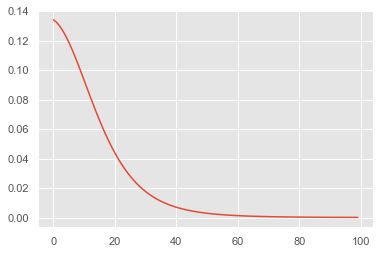

In [158]:
plt.plot(y_plot)

In [125]:
result#[0]

{<scipy.stats._continuous_distns.norm_gen at 0x25821656910>: [0.0003715070761764119,
  (),
  -0.0015537528894924734,
  3.722219707614865],
 <scipy.stats._continuous_distns.t_gen at 0x258216dcaf0>: [0.00044678544573872257,
  (4.812423461463746,),
  0.011085626010042907,
  2.6739985353161693]}

In [127]:
list(result)

In [131]:
results.items()

dict_items([(<scipy.stats._continuous_distns.norm_gen object at 0x0000025821656910>, [0.0003715070761764119, (), -0.0015537528894924734, 3.722219707614865]), (<scipy.stats._continuous_distns.t_gen object at 0x00000258216DCAF0>, [0.00044678544573872257, (4.812423461463746,), 0.011085626010042907, 2.6739985353161693])])

In [132]:
for distribution, result in results.items():
    print(distribution, result)

<scipy.stats._continuous_distns.norm_gen object at 0x0000025821656910> [0.0003715070761764119, (), -0.0015537528894924734, 3.722219707614865]
<scipy.stats._continuous_distns.t_gen object at 0x00000258216DCAF0> [0.00044678544573872257, (4.812423461463746,), 0.011085626010042907, 2.6739985353161693]


In [128]:
{k: result[k] for k in list(result)[:2]}

{<scipy.stats._continuous_distns.norm_gen at 0x25821656910>: [0.0003715070761764119,
  (),
  -0.0015537528894924734,
  3.722219707614865],
 <scipy.stats._continuous_distns.t_gen at 0x258216dcaf0>: [0.00044678544573872257,
  (4.812423461463746,),
  0.011085626010042907,
  2.6739985353161693]}

In [ ]:
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))

In [87]:
ax[i_0][i_1].x

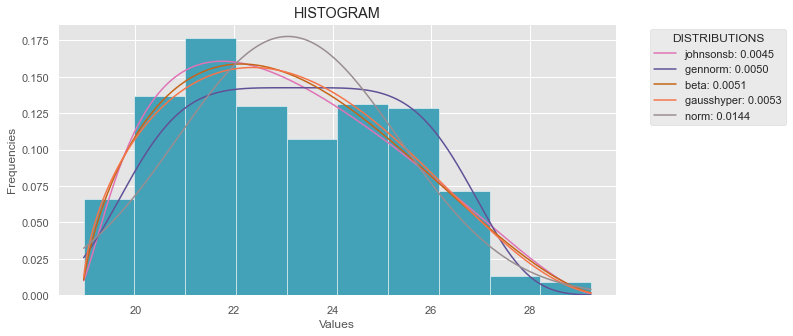

In [106]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random

mpl.style.use("ggplot")

def danoes_formula(data):
    """
    DANOE'S FORMULA
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    ## Histogram of data
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235), bins=100)
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    ## Plot n distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        # print(i, distribution)
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution)[32:-34] + ": " + str(sse)[0:6], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disbled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters
    ALL_DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm, st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm, st.uniform, st.johnsonsb, st.gennorm, st.gausshyper]

    ## Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results
        
def main():
    ## Import data
    data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    results = fit_data(data)
    plot_histogram(data, results, 5)

if __name__ == "__main__":
    main()

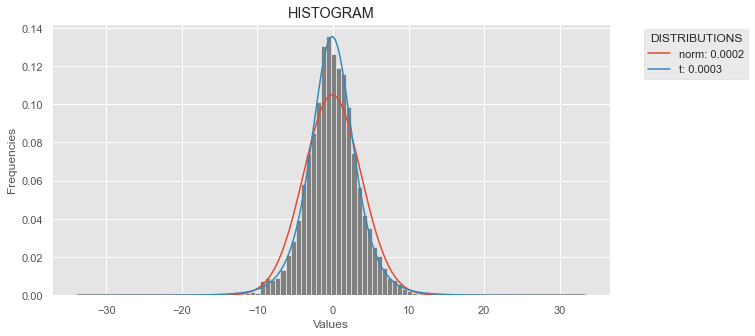

In [116]:
def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    ## Histogram of data
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', bins=100, color="grey")
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    ## Plot n distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        # print(i, distribution)
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution)[32:-34] + ": " + str(sse)[0:6] )
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disbled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters
    ALL_DISTRIBUTIONS = [        
        st.norm,st.t
    ]
    
    MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm, st.uniform, st.johnsonsb, st.gennorm, st.gausshyper]

    ## Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in ALL_DISTRIBUTIONS:
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

results = fit_data(hist_val)
plot_histogram(hist_val, results, 2)

In [120]:
results

{<scipy.stats._continuous_distns.norm_gen at 0x25821656910>: [0.00029919791656237,
  (),
  -0.09854904842729856,
  3.8044863361517565],
 <scipy.stats._continuous_distns.t_gen at 0x258216dcaf0>: [0.0003434325793165355,
  (5.02888173995933,),
  -0.11222433791427569,
  2.804397912068084]}

In [118]:
def plotScaling(j, scaleFactor):
    col_name = rv1.columns[j]
    v = rv1[col_name]
    x = np.arange(1,101)

    def xDel(x, lag):
        return x-x.shift(lag)

    def sdl(lag):
        return (xDel(np.log(v), lag)).std()

    sd1 = (xDel(np.log(v), 1)).std()
    h = OxfordH['h_est'][j]
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10, 10))
    f.suptitle(col_name)
    
    rv = norm()
    
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)

            hist_val = xDel(np.log(v), la).dropna()
            std = hist_val.std()
            mean = hist_val.mean()

            ax[i_0][i_1].set_title('Lag = %s Days' %la)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100, facecolor='green',alpha=0.2)
        
            #ax[i_0][i_1].plot(bins, mlab.normpdf(bins,mean,std), "r")
            #ax[i_0][i_1].plot(bins, mlab.normpdf(bins,0,sd1 * la ** h), "b--")
            #hist_val.plot(kind='density', ax=ax[i_0][i_1])
plotScaling(1,5)

NameError: name 'OxfordH' is not defined

In [ ]:
# Data for other assets:

In [ ]:
ticker_list= ["AAPL", "SPY", "GME", "TSLA", "NIO", "MSFT","T"]

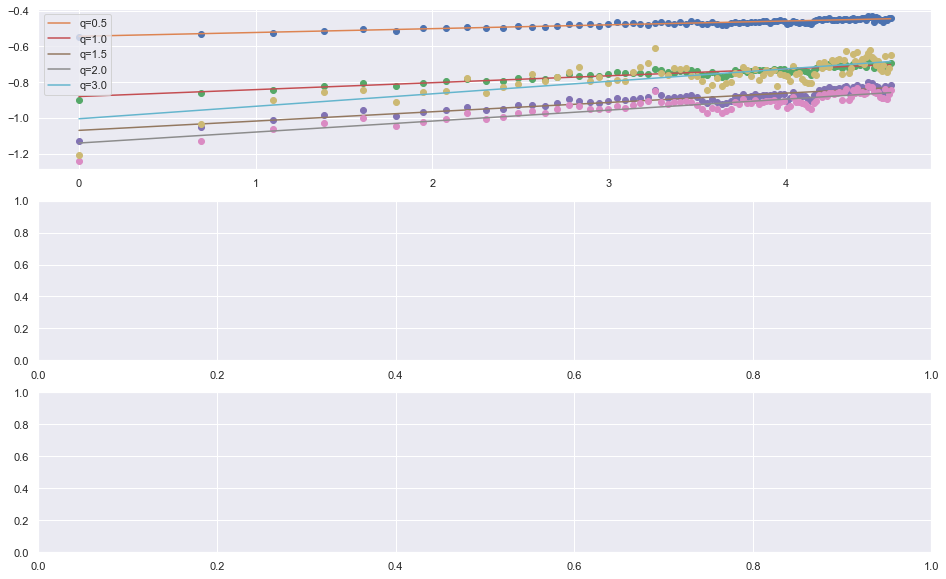

In [56]:
fig, axs =  plt.subplots(3, figsize=(16,10))

# moment generating function
def del_Raw_stocks(q,x):
    m= [np.mean(np.abs(vol_data_df["log_sqrt"] - vol_data_df["log_sqrt"].shift(lag))**q) for lag in x]
    return m

# dataframe to store data
df_value_store = pd.DataFrame()

# define tickers
ticker_list= ["GME"]#["AAPL", "SPY", "GME", "TSLA", "NIO", "MSFT", "T"]

#define start list
days_delta=365*10
dlstart_date = dt.datetime.today() - dt.timedelta(days=days_delta)
dlend_date = dt.datetime.today() - dt.timedelta(days=365*2.5)

for i, ticker in enumerate(ticker_list):
    
    #Download  Data
    ticker_object = yf.Ticker(ticker)
    df_stock_data = ticker_object.history(start=dlstart_date, end=dlend_date)

    var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean = GKYZ_vol(df_stock_data)

    vol_data_df = pd.DataFrame(data=var_gkyz_array, columns=["GKYZ Var"])
    vol_data_df['sqrt']= np.sqrt(vol_data_df["GKYZ Var"])
    vol_data_df['log_sqrt'] = np.log(vol_data_df['sqrt'])
    vol_data_df=vol_data_df[vol_data_df["GKYZ Var"] > 0.]
    vol_data_df=vol_data_df.dropna()

    zeta_q_stocks = list()
    alpha_q_stocks = list()

    qVec =  np.array([.5, 1, 1.5, 2, 3]) #np.arange(0.1,24,50/100) #
    x = np.arange(1, 100)

    for q in qVec:

        # Kernel Estimates
        axs[0].plot(np.log(x), np.log(del_Raw_stocks(q, x)), 'o') 
        model_stocks = np.polyfit(np.log(x), np.log(del_Raw_stocks(q, x)), 1)
        axs[0].plot(np.log(x), np.log(x) * model_stocks[0] + model_stocks[1], label="q={}".format(q))
        axs[0].legend()
        zeta_q_stocks.append(model_stocks[0])
        alpha_q_stocks.append(model_stocks[1])


    nu_est_stocks = np.sqrt(np.exp(np.mean(alpha_q_stocks)))
    line_stocks = np.polyfit(qVec, zeta_q_stocks,1)
    h_est_stocks = line_stocks[0]
    
    
    # Estimating Rho, the correlation between log returns and log volatility
    log_returns = np.log(df_stock_data.loc[:, "Close"]) - np.log(df_stock_data.loc[:, "Close"].shift(1))
    log_returns = log_returns.dropna()
    rho = np.corrcoef(log_returns, vol_data_df.iloc[:,2])[0][1]

    df_value_store.loc[ticker, "nu"] = nu_est_stocks
    df_value_store.loc[ticker, "h"] = h_est_stocks
    df_value_store.loc[ticker, "rho"] = rho
    

    
    

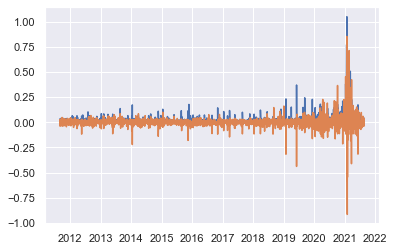

In [54]:
plt.plot(vol_data_df.iloc[:,1])
plt.plot(log_returns)

In [57]:
df_value_store

,nu,h,rho
GME,0.628614,0.018985,-0.140748


In [38]:
days_delta=365*3
dlstart_date = dt.datetime.today() - dt.timedelta(days=days_delta)

ticker="AAPL"
ticker_object = yf.Ticker(ticker)
df_stock_data = ticker_object.history(start=dlstart_date)

var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean = GKYZ_vol(df_stock_data)

vol_data_df = pd.DataFrame(data=var_gkyz_array, columns=["GKYZ Var"])
vol_data_df['sqrt']= np.sqrt(vol_data_df["GKYZ Var"])
vol_data_df['log_sqrt'] = np.log(vol_data_df['sqrt'])
vol_data_df=vol_data_df[vol_data_df["GKYZ Var"] > 0.]
vol_data_df=vol_data_df.dropna()

log_returns = np.log(df_stock_data.loc[:, "Close"]) - np.log(df_stock_data.loc[:, "Close"].shift(1))
log_returns = log_returns.dropna()

rho = np.corrcoef(log_returns, vol_data_df.iloc[:,2])[0][1]
rho

-0.12721487201529794

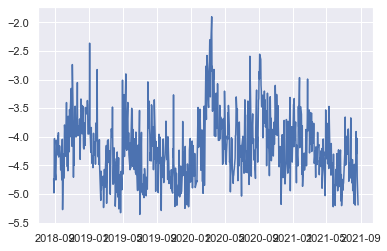

In [10]:
plt.plot(vol_data_df.iloc[:,2])

In [35]:
rho = np.corrcoef(log_returns.dropna(), vol_data_df.iloc[:,2])[0][1]

-0.12706185473053855

In [30]:
log_returns.dropna()

Date
2018-08-27    0.008201
2018-08-28    0.008043
2018-08-29    0.014819
2018-08-30    0.009152
2018-08-31    0.011488
                ...   
2021-08-17   -0.006173
2021-08-18   -0.025832
2021-08-19    0.002320
2021-08-20    0.010106
2021-08-23    0.006253
Name: Close, Length: 753, dtype: float64

In [23]:
pct_return = (df_stock_data["Close"].pct_change().dropna())

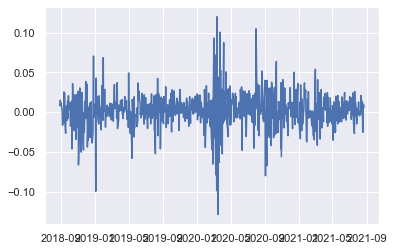

In [15]:
plt.plot(df_stock_data["Close"].pct_change().dropna())

In [13]:
vol_data_df

,GKYZ Var,sqrt,log_sqrt
Date,,,
2018-08-27,0.000077,0.008784,-4.734840
2018-08-28,0.000047,0.006880,-4.979077
2018-08-29,0.000111,0.010531,-4.553461
2018-08-30,0.000315,0.017757,-4.030986
2018-08-31,0.000113,0.010639,-4.543205
...,...,...,...
2021-08-17,0.000183,0.013534,-4.302531
2021-08-18,0.000272,0.016501,-4.104312
2021-08-19,0.000319,0.017863,-4.025024


In [27]:
log_returns = np.log(df_stock_data.loc[:, "Close"]) - np.log(df_stock_data.loc[:, "Close"].shift(1))

In [25]:
SPX

NameError: name 'SPX' is not defined

In [ ]:
np.mean(alpha_q_stocks)

In [ ]:
nu.append(np.sqrt(np.exp(model[1])))

In [200]:
df = pd.DataFrame({"AAPL": [0.1]})
df({"AAPL": [0.1]})

,AAPL
0,0.1


In [212]:
df = pd.DataFrame()
df.loc["AAPL", "nu"] = 0.5
df.loc["AAPL", "h"] = 0.432
df

,nu,h
AAPL,0.5,0.432


In [201]:
df({"AAPL": [0.1]})

TypeError: 'DataFrame' object is not callable

In [194]:
SPX

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,99.392272,99.392272,96.459110,97.506668,8164300,0.0,0
2000-01-04,96.228663,96.584833,93.620244,93.693573,8089800,0.0,0
2000-01-05,93.819273,94.887782,92.017474,93.861176,12177900,0.0,0
2000-01-06,93.609745,94.866815,92.352676,92.352676,6227200,0.0,0
2000-01-07,94.070708,97.716209,93.903098,97.716209,8066500,0.0,0
...,...,...,...,...,...,...,...
2017-11-28,243.687795,245.687672,243.584982,245.659637,98971700,0.0,0
2017-11-29,245.799772,246.369850,245.033480,245.510071,77512100,0.0,0
2017-11-30,246.491400,248.631451,246.407296,247.659561,127894400,0.0,0


Text(0.5, 1.0, 'SPX Daily Volume')

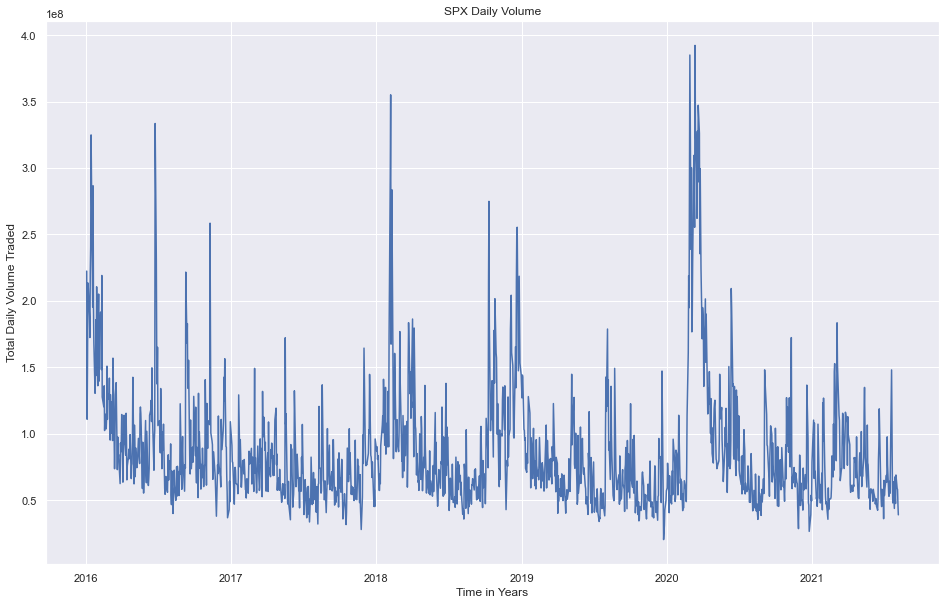

In [239]:
ticker_object = yf.Ticker("SPY")
df_stock_data = ticker_object.history(start="2016-01-03")
plt.figure(figsize=(16,10))
plt.plot(df_stock_data["Volume"])
plt.xlabel("Time in Years")
plt.ylabel("Total Daily Volume Traded")
plt.title("SPX Daily Volume")

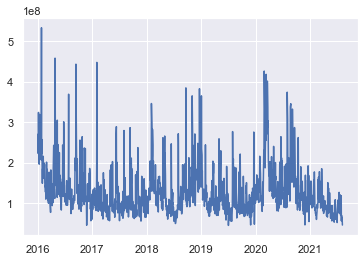

In [170]:
dt.datetime.today()

datetime.datetime(2021, 8, 5, 18, 20, 18, 76783)

In [174]:
dt.datetime()

TypeError: an integer is required (got type str)

In [175]:
"2019-01-01"

'2019-01-01'

In [184]:
days_delta=365*3
dlstart_date = dt.datetime.today() - dt.timedelta(days=days_delta)

In [71]:
vol_data_df.iloc[:,0]

Date
2011-08-29    0.000233
2011-08-30    0.000798
2011-08-31    0.000320
2011-09-01    0.000331
2011-09-02    0.000531
                ...   
2019-02-15    0.000069
2019-02-19    0.000256
2019-02-20    0.000094
2019-02-21    0.000198
2019-02-22    0.000140
Name: GKYZ Var, Length: 1883, dtype: float64

In [72]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(ldata)
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

def xi(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    rvdata = pd.DataFrame(vol_data_df.iloc[:,0])
    return [ forecast_XTS(rvdata,h=h,date=date,nLags=500,delta=dt*tscale,nu=nu) for dt in tt]

def varSwapCurve(date, bigT, nSteps, nu, h, tscale, onFactor):
    # Make vector of fwd variances
    tt = [ float(i) * (bigT) / nSteps for i in range(nSteps+1)]
    delta_t = tt[1]
    xicurve = xi(date, tt, nu, h, tscale)
    xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps+1])) / 2
    xicurve_int = np.cumsum(xicurve_mid) * delta_t
    varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
    varcurve = np.array([xicurve[0],]+list(varcurve1))
    varcurve = varcurve * onFactor * tscale #  onFactor is to compensate for overnight moves
    res = pd.DataFrame({"texp":np.array(tt), "vsQuote":np.sqrt(varcurve)})
    return(res)

def slopes(x,y):
    """
    :func:`slopes` calculates the slope *y*'(*x*)
    The slope is estimated using the slope obtained from that of a
    parabola through any three consecutive points.
    This method should be superior to that described in the appendix
    of A CONSISTENTLY WELL BEHAVED METHOD OF INTERPOLATION by Russel
    W. Stineman (Creative Computing July 1980) in at least one aspect:
      Circles for interpolation demand a known aspect ratio between
      *x*- and *y*-values.  For many functions, however, the abscissa
      are given in different dimensions, so an aspect ratio is
      completely arbitrary.
    The parabola method gives very similar results to the circle
    method for most regular cases but behaves much better in special
    cases.
    Norbert Nemec, Institute of Theoretical Physics, University or
    Regensburg, April 2006 Norbert.Nemec at physik.uni-regensburg.de
    (inspired by a original implementation by Halldor Bjornsson,
    Icelandic Meteorological Office, March 2006 halldor at vedur.is)
    """
    # Cast key variables as float.
    x=np.asarray(x, np.float_)
    y=np.asarray(y, np.float_)

    yp=np.zeros(y.shape, np.float_)

    dx=x[1:] - x[:-1]
    dy=y[1:] - y[:-1]
    dydx = dy/dx
    yp[1:-1] = (dydx[:-1] * dx[1:] + dydx[1:] * dx[:-1])/(dx[1:] + dx[:-1])
    yp[0] = 2.0 * dy[0]/dx[0] - yp[1]
    yp[-1] = 2.0 * dy[-1]/dx[-1] - yp[-2]
    return yp


def stineman_interp(xi,x,y,yp=None):
    """
    Given data vectors *x* and *y*, the slope vector *yp* and a new
    abscissa vector *xi*, the function :func:`stineman_interp` uses
    Stineman interpolation to calculate a vector *yi* corresponding to
    *xi*.
    Here's an example that generates a coarse sine curve, then
    interpolates over a finer abscissa::
      x = linspace(0,2*pi,20);  y = sin(x); yp = cos(x)
      xi = linspace(0,2*pi,40);
      yi = stineman_interp(xi,x,y,yp);
      plot(x,y,'o',xi,yi)
    The interpolation method is described in the article A
    CONSISTENTLY WELL BEHAVED METHOD OF INTERPOLATION by Russell
    W. Stineman. The article appeared in the July 1980 issue of
    Creative Computing with a note from the editor stating that while
    they were:
      not an academic journal but once in a while something serious
      and original comes in adding that this was
      "apparently a real solution" to a well known problem.
    For *yp* = *None*, the routine automatically determines the slopes
    using the :func:`slopes` routine.
    *x* is assumed to be sorted in increasing order.
    For values ``xi[j] < x[0]`` or ``xi[j] > x[-1]``, the routine
    tries an extrapolation.  The relevance of the data obtained from
    this, of course, is questionable...
    Original implementation by Halldor Bjornsson, Icelandic
    Meteorolocial Office, March 2006 halldor at vedur.is
    Completely reworked and optimized for Python by Norbert Nemec,
    Institute of Theoretical Physics, University or Regensburg, April
    2006 Norbert.Nemec at physik.uni-regensburg.de
    """

    # Cast key variables as float.
    x=np.asarray(x, np.float_)
    y=np.asarray(y, np.float_)
    assert x.shape == y.shape
    N=len(y)

    if yp is None:
        yp = slopes(x,y)
    else:
        yp=np.asarray(yp, np.float_)

    xi=np.asarray(xi, np.float_)
    yi=np.zeros(xi.shape, np.float_)

    # calculate linear slopes
    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    s = dy/dx  #note length of s is N-1 so last element is #N-2

    # find the segment each xi is in
    # this line actually is the key to the efficiency of this implementation
    idx = np.searchsorted(x[1:-1], xi)

    # now we have generally: x[idx[j]] <= xi[j] <= x[idx[j]+1]
    # except at the boundaries, where it may be that xi[j] < x[0] or xi[j] > x[-1]

    # the y-values that would come out from a linear interpolation:
    sidx = s.take(idx)
    xidx = x.take(idx)
    yidx = y.take(idx)
    xidxp1 = x.take(idx+1)
    yo = yidx + sidx * (xi - xidx)

    # the difference that comes when using the slopes given in yp
    dy1 = (yp.take(idx)- sidx) * (xi - xidx)       # using the yp slope of the left point
    dy2 = (yp.take(idx+1)-sidx) * (xi - xidxp1) # using the yp slope of the right point

    dy1dy2 = dy1*dy2
    # The following is optimized for Python. The solution actually
    # does more calculations than necessary but exploiting the power
    # of numpy, this is far more efficient than coding a loop by hand
    # in Python
    yi = yo + dy1dy2 * np.choose(np.array(np.sign(dy1dy2), np.int32)+1,
                                 ((2*xi-xidx-xidxp1)/((dy1-dy2)*(xidxp1-xidx)),
                                  0.0,
                                  1/(dy1+dy2),))
    return yi

def varSwapForecast(date,tau,nu,h,tscale,onFactor):
    vsc = varSwapCurve(date, bigT=2.5, nSteps=100, nu=nu, h=h,
                    tscale=tscale, onFactor=onFactor) # Creates the whole curve
    x = vsc['texp']
    y = vsc['vsQuote']
    res = stineman_interp(tau,x,y,None)

    return(res)

# Test the function

#tau = (.25,.5,1,2)
#date = dt.datetime(2008,9,8)
#varSwapForecast(date,tau,nu=nu,h=h,tscale=252,onFactor=1)

In [110]:
tau2=[0.019, 0.038, 0.058, 0.077, 0.096, 0.153, 0.230, 0.307, 0.403, 0.479, 0.575, 0.978, 1.227, 1.573, 1.726, 1.975]
date2=dt.datetime.today().date()

result=varSwapForecast(date2,tau2,nu=0.628614,h=0.018985,tscale=252,onFactor=1)

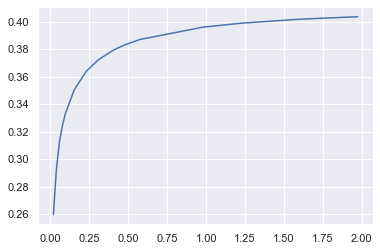

In [121]:
plt.plot(tau2, result)

In [117]:
np.flip(result)

array([0.40354083, 0.40238794, 0.40151811, 0.39885121, 0.39593344,
       0.38700087, 0.38318148, 0.37919987, 0.37219897, 0.36381554,
       0.35043251, 0.33315822, 0.32443824, 0.31271283, 0.29252915,
       0.2597822 ])

In [146]:
n=np.arange(0,10, 0.01)
n

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

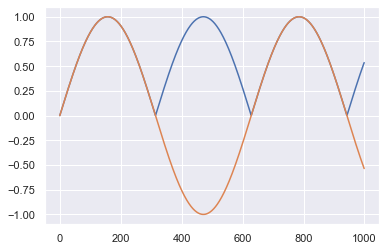

In [148]:
plt.plot(np.abs(np.sin(n)))
plt.plot((np.sin(n)))

In [ ]:
# Appendix


# OLD CODE


#"Missing N from calculations! Paper is wrong?"#

def GKYZ_vol(SPX):
    
    # Estimating over total Range
    a_list = list()
    b_list = list()
    c_list = list()

    N = len(SPX) # number of days
    F = 1 # samples per day
    window = 1 # avg num days in a month: 22
    horizon = window # The time horizon of the estimation, yearly_vol=252, monthly_vol=22, daily_vol=1

    for i in range(len(SPX)):
        try:
            high_t = SPX.iloc[i+1,0]
            low_t = SPX.iloc[i+1,1]

            open_t0 = SPX.iloc[i,2]
            open_t = SPX.iloc[i+1,2]

            close_t0 = SPX.iloc[i,3]
            close_t = SPX.iloc[i+1,3]

            a = np.log(open_t/close_t0)**2
            b = (1/2) * np.log(high_t/low_t)**2
            c = (2 * np.log(2) - 1) * np.log(close_t/open_t)**2

            a_list.append(a)
            b_list.append(b)
            c_list.append(c)
        except IndexError:
            pass

    var_GKYZ_daily_mean = 1/N * (np.sum(a_list) + np.sum(b_list) - np.sum(c_list))  # Daily var
    vol_GKYZ_daily_mean = np.sqrt(var_GKYZ_daily_mean)  # Daily vol
    
    # Compute Rolling Window of Volatility
    var_gkyz_array = 1/window * (
                                    np.log(SPX.loc[:, "Open"] / SPX.loc[:, "Close"].shift(1))**2 + 
                                    (1/2) * np.log(SPX.loc[:, "High"] / SPX.loc[:, "Low"])**2 - 
                                    (2* np.log(2) - 1) * np.log(SPX.loc[:,"Close"] / SPX.loc[:, "Open"])**2
                                ).rolling(window=window).sum()
    vol_gkyz_array = np.sqrt(var_gkyz_array)
    
    
    
    return var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean

var_gkyz_array, vol_gkyz_array, var_GKYZ_daily_mean, vol_GKYZ_daily_mean = GKYZ_vol(SPX)

spx2 = pd.DataFrame(data=var_gkyz_array, columns=["GKYZ Var"])
spx2['sqrt']= np.sqrt(spx2["GKYZ Var"])
spx2['log_sqrt'] = np.log(spx2['sqrt'])
spx2=spx2[spx2["GKYZ Var"] > 0.]
spx2=spx2.dropna()